In [1]:
import os
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import doubletdetection
from scipy.stats import median_abs_deviation as mad
import numpy as np

In [2]:
import warnings
warnings.simplefilter("ignore",FutureWarning)
warnings.simplefilter("ignore",UserWarning)
warnings.simplefilter("ignore",RuntimeWarning)

In [3]:
count_matrix_path = "/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/OMIX002441-01.csv"
tang_metadata_path = "/hpc/users/divagt01/watanabe/Divagar/transcriptomic_data/Tang/OMIX002441-02.csv"


In [4]:
df = pd.read_csv(count_matrix_path, index_col=0, header=0)
df_transposed = df.T
tang_metadata = pd.read_csv(tang_metadata_path, index_col=0, header=0)

In [5]:
tang_adata = sc.AnnData(df_transposed.values)
tang_adata.obs_names = df_transposed.index
tang_adata.var_names = df_transposed.columns


In [6]:
tang_adata.obs = tang_adata.obs.join(tang_metadata['patient'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['NT'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['tissue'])
tang_adata.obs = tang_adata.obs.join(tang_metadata['cell_type'])


In [7]:
# QC
def qc(adata):
    sc.pp.filter_cells(adata, min_genes=200)
    adata.var["mt"]=adata.var_names.str.startswith("MT-")
    adata.var["ribo"]=adata.var_names.str.startswith(("RPS","RPL"))
    adata.var["hb"]=adata.var_names.str.contains(("^HB[^(P)]"))
    sc.pp.calculate_qc_metrics(adata,qc_vars=["mt","ribo","hb"], inplace=True, percent_top=[20], log1p=True)

    remove = ["total_counts_mt","log1p_total_counts_mt","total_counts_ribo","log1p_total_counts_ribo","total_counts_hb","log1p_total_counts_hb"]
    adata.obs=adata.obs[[x for x in adata.obs.columns if x not in remove]]
    
    return adata

In [8]:
qc(tang_adata)

AnnData object with n_obs × n_vars = 5025 × 24153
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

In [9]:
%matplotlib inline

Text(0, 0.5, '% Counts per cell mapping to rRNAs')

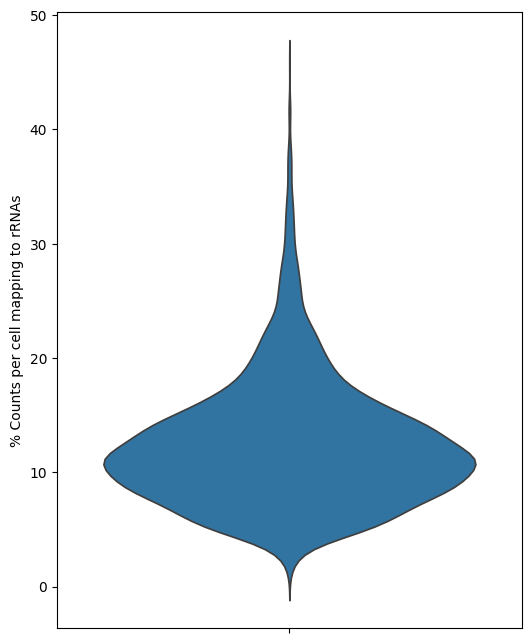

In [10]:
ribo_pct_data = tang_adata.obs['pct_counts_ribo']
plt.figure(figsize=(6, 8))
sns.violinplot(y=ribo_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to rRNAs')

Text(0, 0.5, '% Counts per cell mapping to Hemoglobin genes')

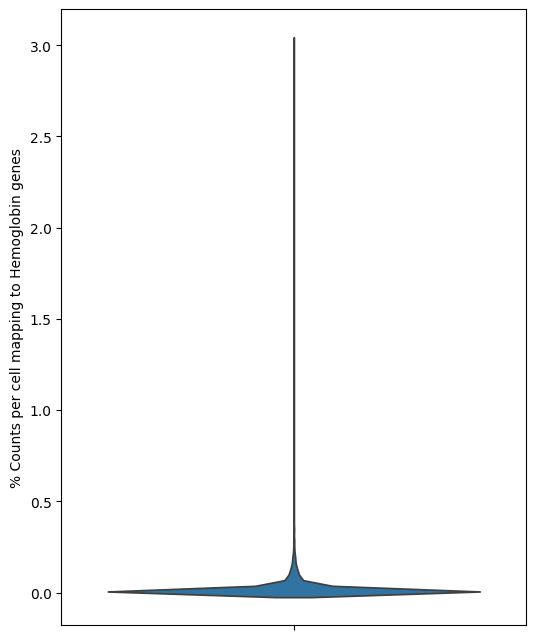

In [11]:
hb_pct_data = tang_adata.obs['pct_counts_hb']
plt.figure(figsize=(6, 8))
sns.violinplot(y=hb_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to Hemoglobin genes')

Text(0, 0.5, '% Counts per cell mapping to Mitochondrial genes')

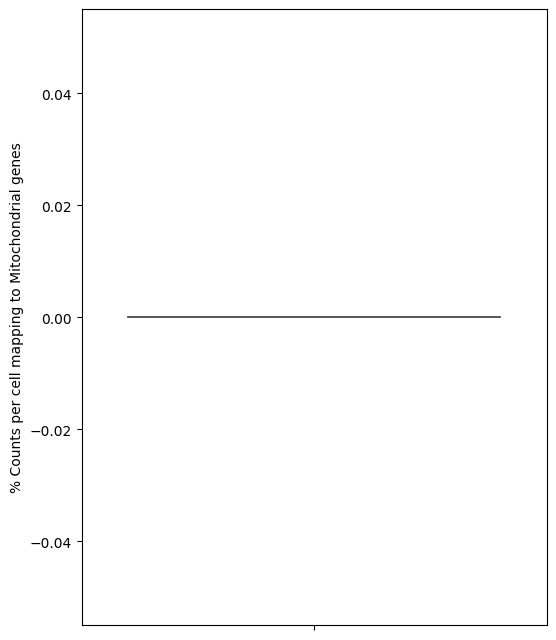

In [12]:
mt_pct_data = tang_adata.obs['pct_counts_mt']
plt.figure(figsize=(6, 8))
sns.violinplot(y=mt_pct_data, inner=None)
plt.ylabel('% Counts per cell mapping to Mitochondrial genes')

Text(0, 0.5, 'Number of genes with mapped transcripts per cell')

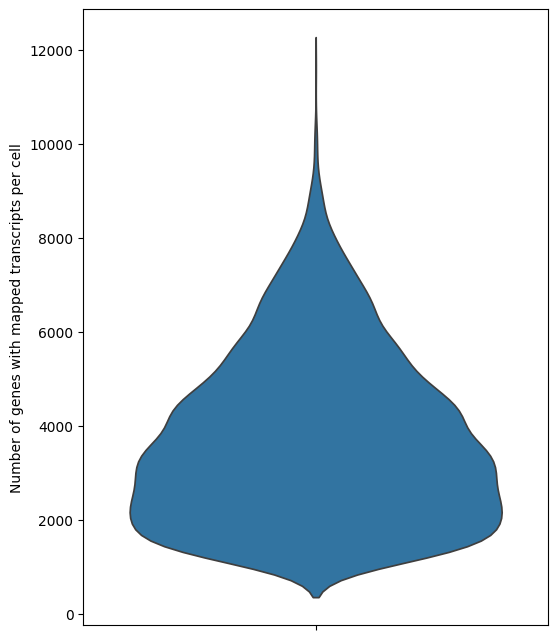

In [13]:
genes_data = tang_adata.obs['n_genes']
plt.figure(figsize=(6, 8))
sns.violinplot(y=genes_data, inner=None)
plt.ylabel('Number of genes with mapped transcripts per cell')

Text(0, 0.5, '% Counts mapped to top 20 genes per cell')

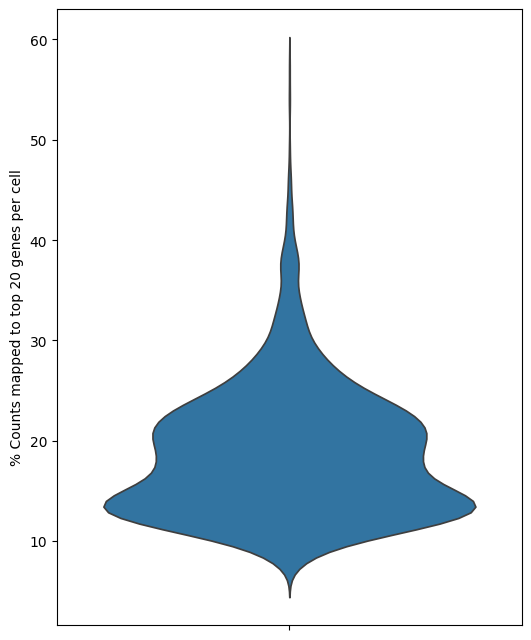

In [14]:
genes_top20_data = tang_adata.obs['pct_counts_in_top_20_genes']
plt.figure(figsize=(6, 8))
sns.violinplot(y=genes_top20_data, inner=None)
plt.ylabel('% Counts mapped to top 20 genes per cell')

Text(0, 0.5, 'Log of number of reads per cell')

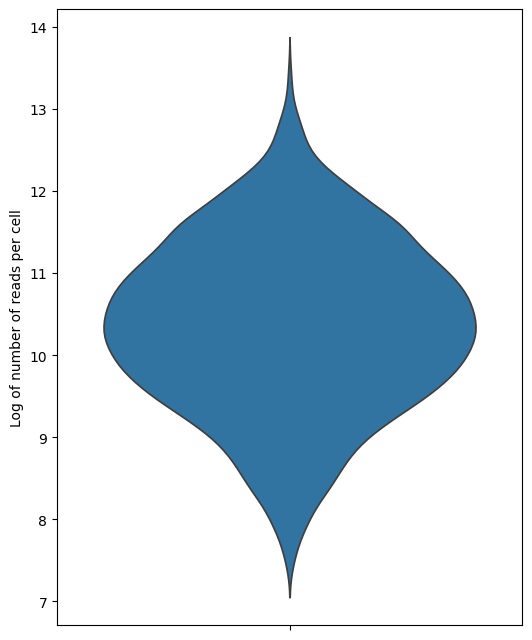

In [15]:
total_counts_data = tang_adata.obs['log1p_total_counts']
plt.figure(figsize=(6, 8))
sns.violinplot(y=total_counts_data, inner=None)
plt.ylabel('Log of number of reads per cell')

In [16]:
a = tang_adata.obs["log1p_total_counts"]

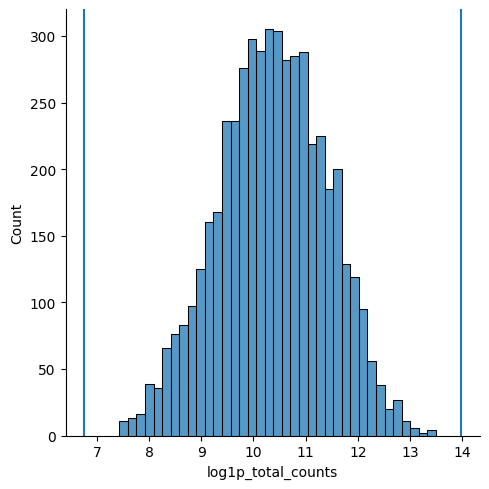

In [17]:
ax = sns.displot(a)
plt.axvline(np.median(a) - 5 * mad(a))
plt.axvline(np.median(a) + 5 * mad(a))
plt.show()

In [18]:
def mad_outlier(adata,metric,nmads,upper_only=False):
    M = adata.obs[metric]

    if not upper_only:
        return (M < np.median(M) - nmads * mad(M)) | (M > np.median(M) + nmads * mad(M))
    return (M > np.median(M) + nmads * mad(M))

In [19]:
def pp(adata):
    adata = adata[adata.obs.pct_counts_mt < 25] 
    
    bool_vector = mad_outlier(adata, 'log1p_total_counts', 5) +\
            mad_outlier(adata, 'log1p_n_genes_by_counts', 5) +\
            mad_outlier(adata, 'pct_counts_in_top_20_genes', 5) +\
            mad_outlier(adata, 'pct_counts_mt', 3, upper_only = True)
    adata = adata[~bool_vector]

    adata.uns['cells_removed'] = sum(bool_vector)

    return adata

In [20]:
tang_adata = pp(tang_adata)

In [21]:
print(tang_adata.uns["cells_removed"])

52


In [22]:
tang_adata

AnnData object with n_obs × n_vars = 4973 × 24153
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'cells_removed'

In [23]:
tang_adata.obs['cell_type']

SCLC_P1_PTR1_B1_1     Mast
SCLC_P1_PTR1_B1_2      Mye
SCLC_P1_PTR1_B1_3      Mye
SCLC_P1_PTR1_B1_4    Tcell
SCLC_P1_PTR1_B1_5      Mye
                     ...  
SCLC_P2_M_B3_92      tumor
SCLC_P2_M_B3_93      tumor
SCLC_P2_M_B3_94      tumor
SCLC_P2_M_B3_95      tumor
SCLC_P2_M_B3_96      Bcell
Name: cell_type, Length: 4973, dtype: object

In [24]:
tumor_adata = tang_adata[tang_adata.obs['cell_type'] == 'tumor', :]


In [25]:
cell_counts = tumor_adata.obs['patient'].value_counts()


In [26]:
cell_counts

patient
P2     335
P3     332
P13    274
P10    272
P11    252
P4     252
P7     221
P12    100
P5      57
P14      7
P1       2
Name: count, dtype: int64

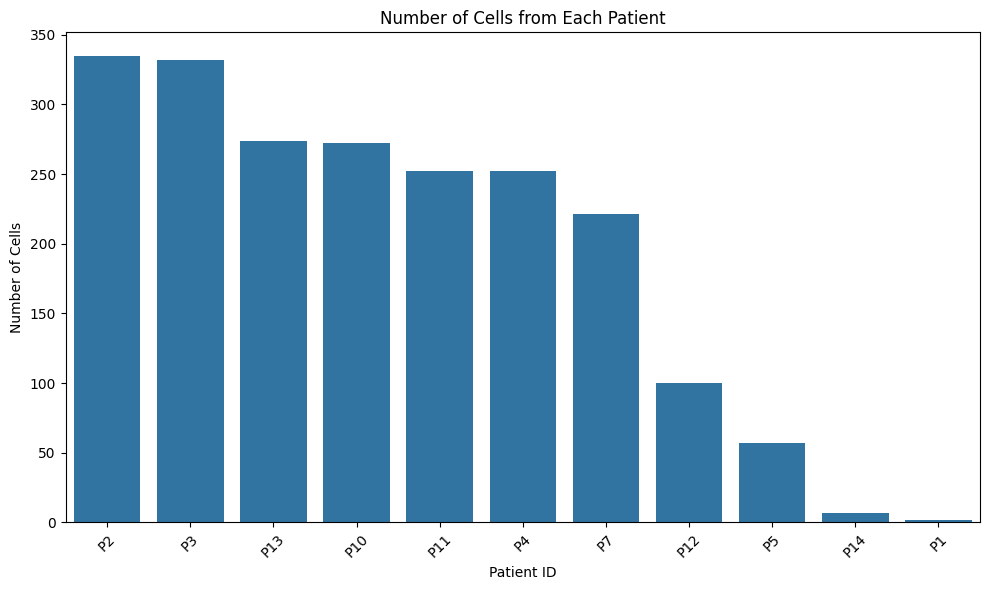

In [27]:
plt.figure(figsize=(10, 6))
sns.barplot(x=cell_counts.index, y=cell_counts.values)
plt.xlabel('Patient ID')
plt.ylabel('Number of Cells')
plt.title('Number of Cells from Each Patient')
plt.xticks(rotation=45)
plt.tight_layout()

In [38]:
tumor_adata_filtered = tumor_adata[~tumor_adata.obs['patient'].isin(['P1', 'P14']), :]

In [39]:
sc.pp.normalize_total(tumor_adata_filtered, target_sum=1e6, exclude_highly_expressed=True)

In [40]:
sc.pp.log1p(tumor_adata_filtered)


In [41]:
sc.pp.scale(tumor_adata_filtered)


In [42]:
sc.tl.pca(tumor_adata_filtered, svd_solver='arpack')


In [45]:
variance_explained = tumor_adata_filtered.uns['pca']['variance_ratio']
variance_explained_percentage = variance_explained * 100

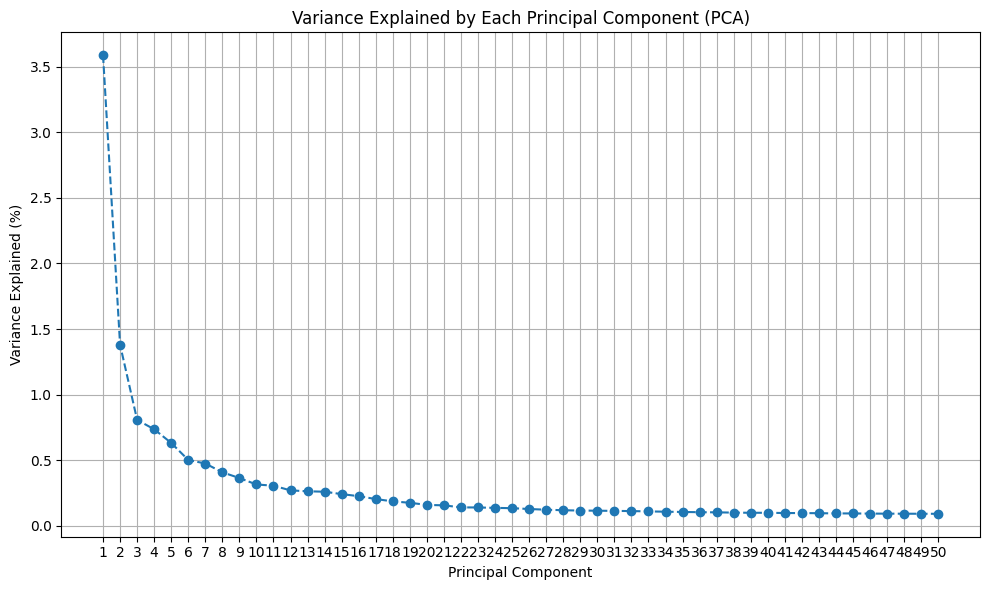

In [46]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(variance_explained_percentage) + 1), variance_explained_percentage, marker='o', linestyle='--')
plt.title('Variance Explained by Each Principal Component (PCA)')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained (%)')
plt.xticks(range(1, len(variance_explained_percentage) + 1))
plt.grid(True)
plt.tight_layout()

In [47]:
sc.pp.neighbors(tumor_adata_filtered, metric='cosine')
sc.tl.umap(tumor_adata_filtered)

In [48]:
tumor_adata_filtered

AnnData object with n_obs × n_vars = 2095 × 24153
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cells_removed', 'log1p', 'pca', 'neighbors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

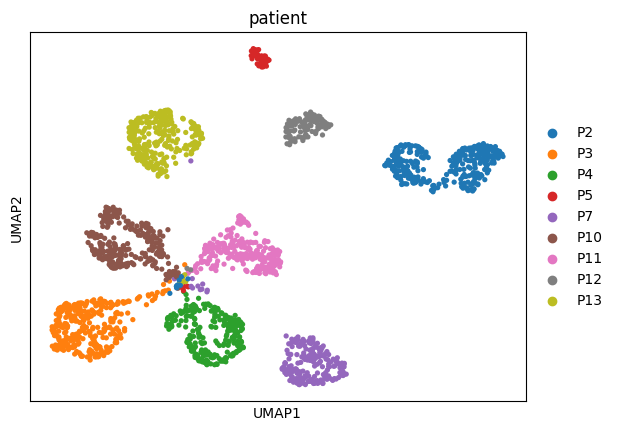

In [49]:
sc.pl.umap(tumor_adata_filtered, color='patient')

In [54]:
lineage_genes = ['ASCL1', 'NEUROD1', 'POU2F3']

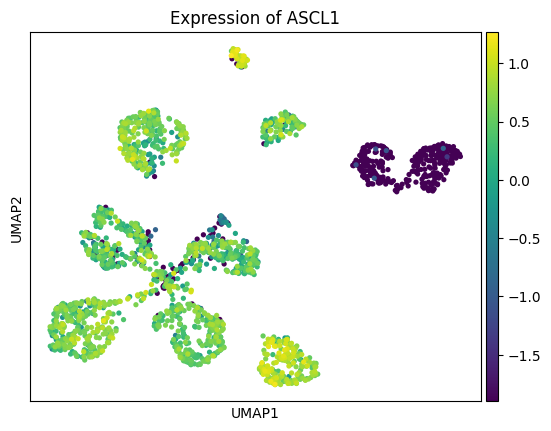

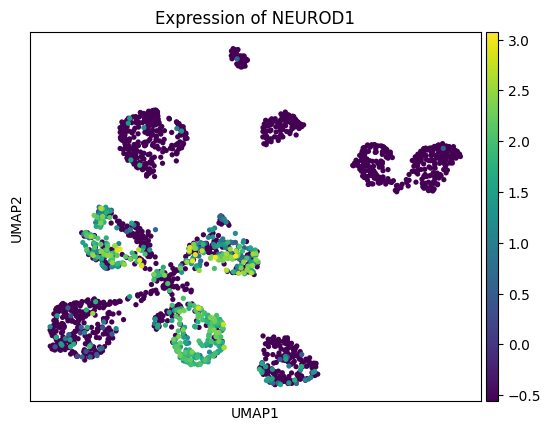

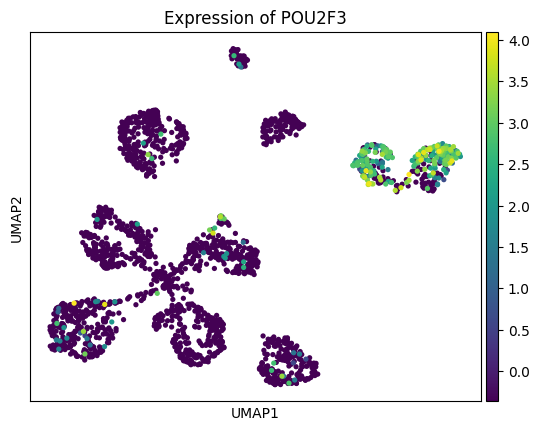

In [138]:
for gene in lineage_genes:
    sc.pl.umap(tumor_adata_filtered, color=gene, title=f'Expression of {gene}')

In [56]:
myc_family_genes = ['MYCL', 'MYC', 'MYCN']

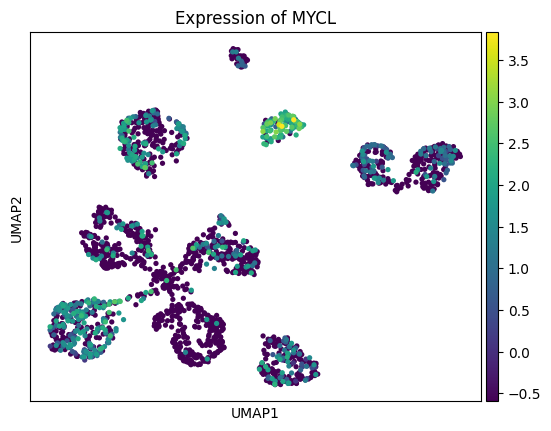

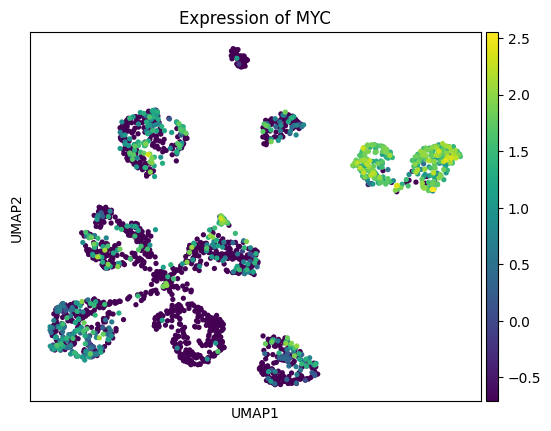

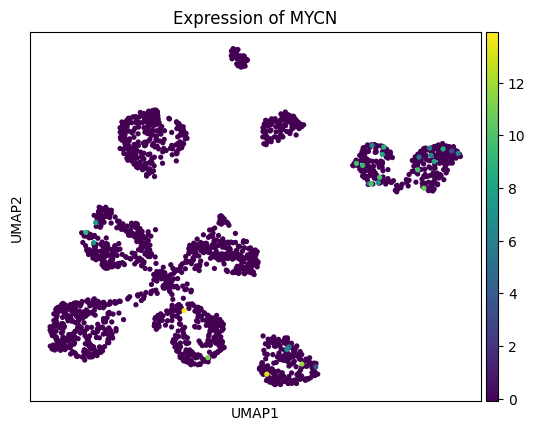

In [139]:
for gene in myc_family_genes:
    sc.pl.umap(tumor_adata_filtered, color=gene, title=f'Expression of {gene}')

In [59]:
ascl1_expr = tumor_adata_filtered.X[:, tumor_adata_filtered.var_names.get_loc('ASCL1')].flatten()


In [60]:
ascl1_expr

array([-1.9008565, -1.9008565, -1.9008565, ..., -1.9008565, -1.9008565,
       -1.9008565], dtype=float32)

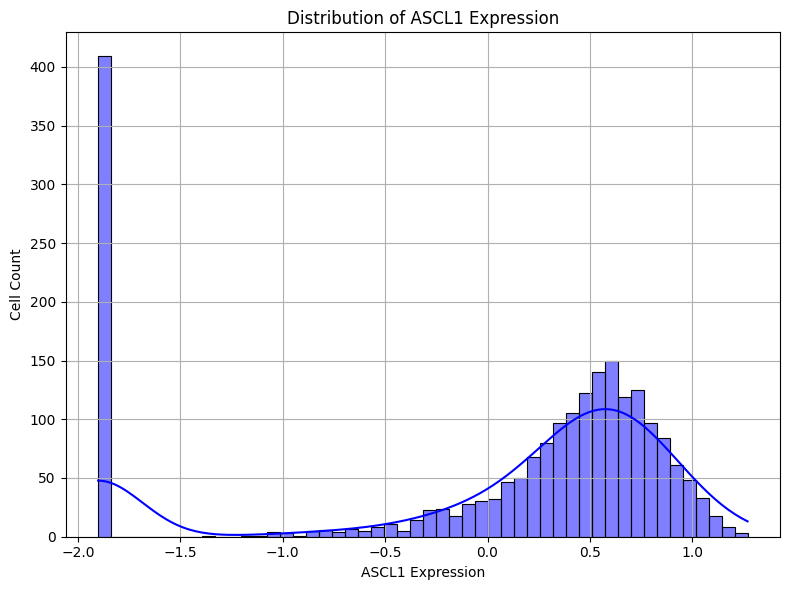

In [61]:
plt.figure(figsize=(8, 6))
sns.histplot(ascl1_expr, kde=True, bins=50, color='blue')
plt.title('Distribution of ASCL1 Expression')
plt.xlabel('ASCL1 Expression')
plt.ylabel('Cell Count')
plt.grid(True)
plt.tight_layout()

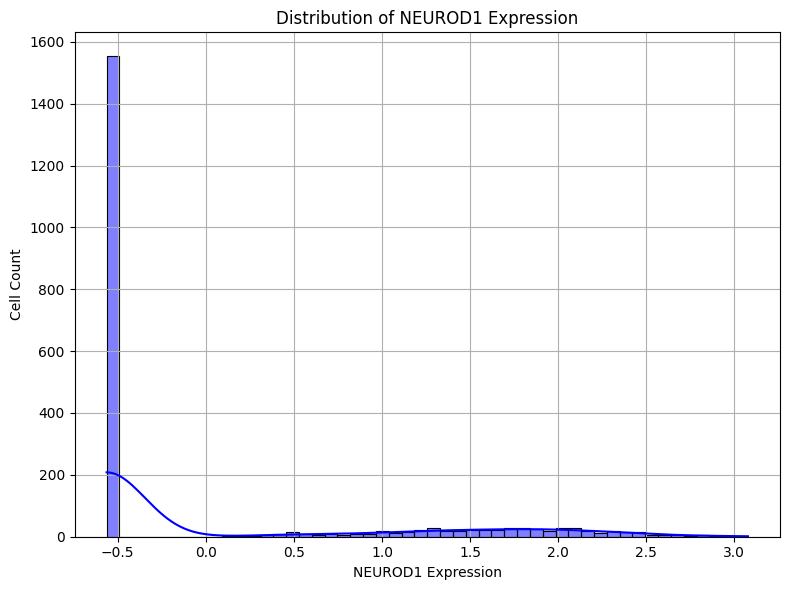

In [62]:
neurod1_expr = tumor_adata_filtered.X[:, tumor_adata_filtered.var_names.get_loc('NEUROD1')].flatten()
plt.figure(figsize=(8, 6))
sns.histplot(neurod1_expr, kde=True, bins=50, color='blue')
plt.title('Distribution of NEUROD1 Expression')
plt.xlabel('NEUROD1 Expression')
plt.ylabel('Cell Count')
plt.grid(True)
plt.tight_layout()

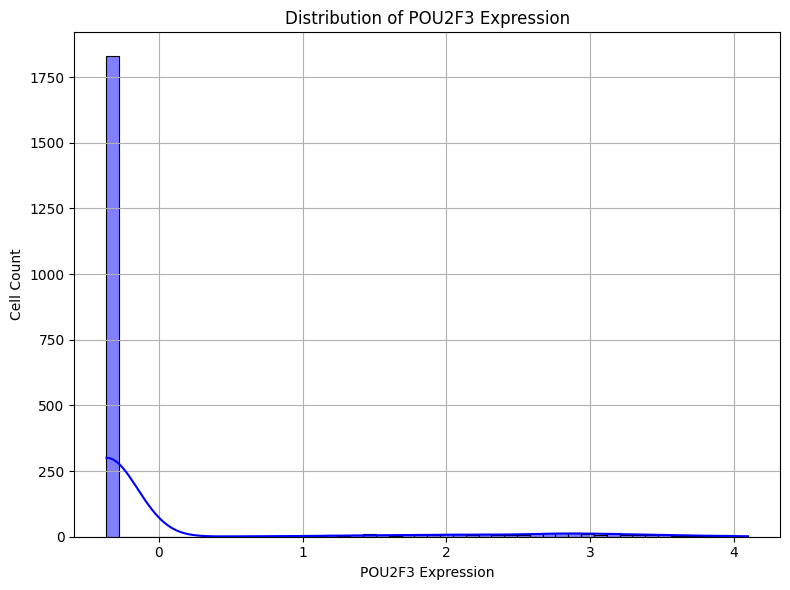

In [63]:
pou2f3_expr = tumor_adata_filtered.X[:, tumor_adata_filtered.var_names.get_loc('POU2F3')].flatten()
plt.figure(figsize=(8, 6))
sns.histplot(pou2f3_expr, kde=True, bins=50, color='blue')
plt.title('Distribution of POU2F3 Expression')
plt.xlabel('POU2F3 Expression')
plt.ylabel('Cell Count')
plt.grid(True)
plt.tight_layout()

In [123]:
genes_of_interest = ['ASCL1', 'NEUROD1', 'POU2F3']
present_genes = [gene for gene in genes_of_interest if gene in tumor_adata_filtered.var_names]
mask = np.logical_or.reduce([
        tumor_adata_filtered.X[:, tumor_adata_filtered.var_names.get_loc(gene)] > 0
        for gene in present_genes
    ])
tumor_adata_filtered_subset = tumor_adata_filtered[mask]

In [124]:
tumor_adata_filtered_subset


View of AnnData object with n_obs × n_vars = 1815 × 24153
    obs: 'patient', 'NT', 'tissue', 'cell_type', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'subtype'
    var: 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'mean', 'std'
    uns: 'cells_removed', 'log1p', 'pca', 'neighbors', 'umap', 'patient_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

In [125]:
expression_data = tumor_adata_filtered_subset.X[:, [tumor_adata_filtered_subset.var_names.get_loc(gene) for gene in present_genes]]
highest_gene_indices = np.argmax(expression_data, axis=1)
subtype_mapping = {0: 'SCLC-A', 1: 'SCLC-N', 2: 'SCLC-P'}
tumor_adata_filtered_subset.obs['subtype'] = [subtype_mapping[i] for i in highest_gene_indices]


In [126]:
tumor_adata_filtered_subset.obs[['subtype']].head()

,subtype
SCLC_P2_PTR1_B1_58,SCLC-P
SCLC_P2_PTR1_B1_80,SCLC-P
SCLC_P2_PTR2_B1_3,SCLC-P
SCLC_P2_PTR2_B1_7,SCLC-P
SCLC_P2_PTR2_B1_15,SCLC-P


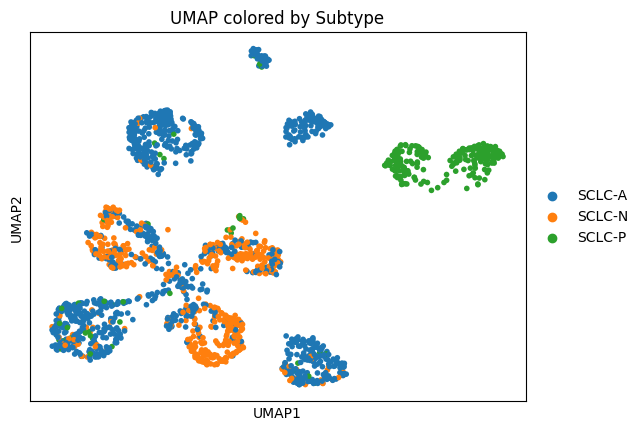

In [127]:
sc.pl.umap(tumor_adata_filtered_subset, color='subtype', title='UMAP colored by Subtype', palette=['#1f77b4', '#ff7f0e', '#2ca02c'])


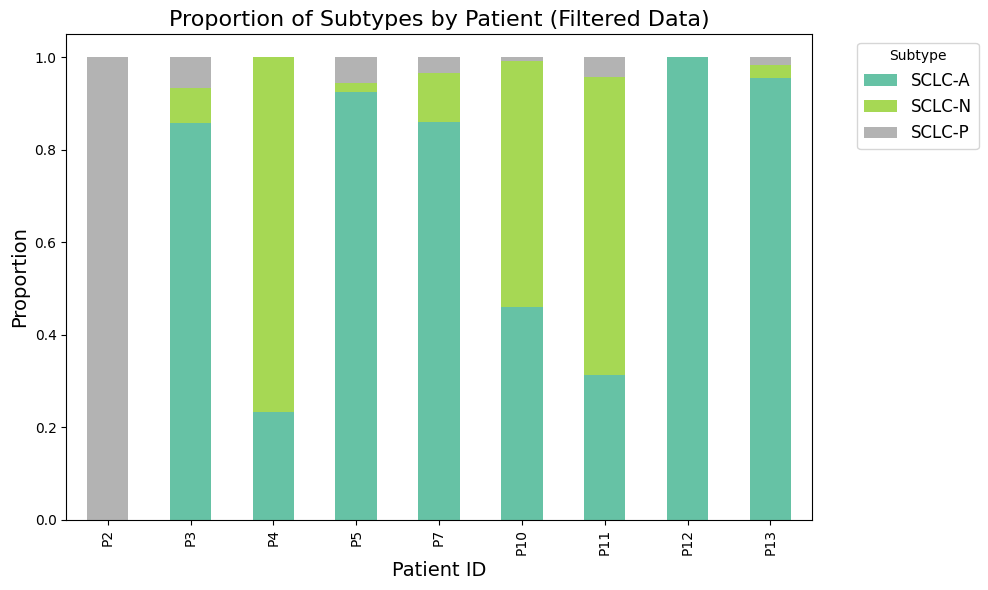

In [128]:
df = tumor_adata_filtered_subset.obs[['subtype', 'patient']]
# Compute proportions of subtypes per patient
subtype_proportions = df.groupby(['patient', 'subtype']).size().unstack(fill_value=0)
    
    # Normalize the proportions so that they sum to 1 for each patient
subtype_proportions = subtype_proportions.div(subtype_proportions.sum(axis=1), axis=0)

    # Plot stacked bar plot
ax = subtype_proportions.plot(kind='bar', stacked=True, figsize=(10, 6), colormap='Set2')

    # Customize the plot
ax.set_title('Proportion of Subtypes by Patient (Filtered Data)', fontsize=16)
ax.set_xlabel('Patient ID', fontsize=14)
ax.set_ylabel('Proportion', fontsize=14)
ax.legend(title='Subtype', fontsize=12, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

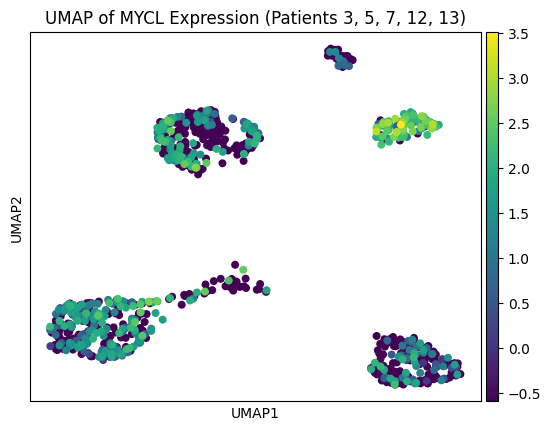

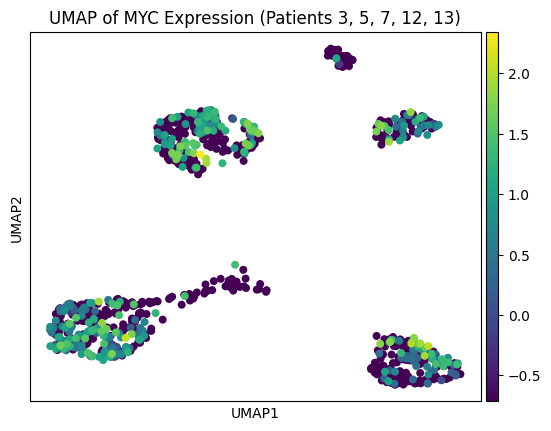

In [129]:
patients_of_interest = ['P3', 'P5', 'P7', 'P12', 'P13']
tumor_adata_filtered_subset1 = tumor_adata_filtered_subset[tumor_adata_filtered_subset.obs['patient'].isin(patients_of_interest)]
sc.pl.umap(tumor_adata_filtered_subset1, color='MYCL', title='UMAP of MYCL Expression (Patients 3, 5, 7, 12, 13)')
sc.pl.umap(tumor_adata_filtered_subset1, color='MYC', title='UMAP of MYC Expression (Patients 3, 5, 7, 12, 13)')




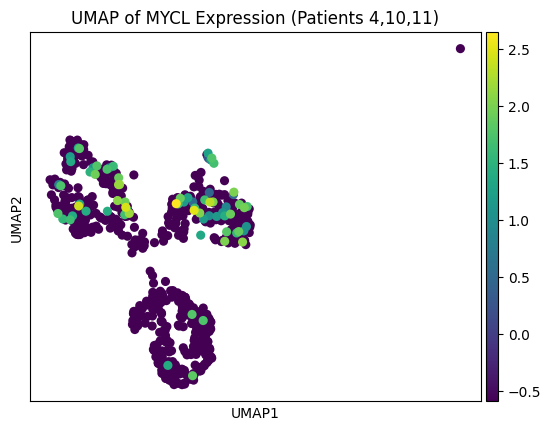

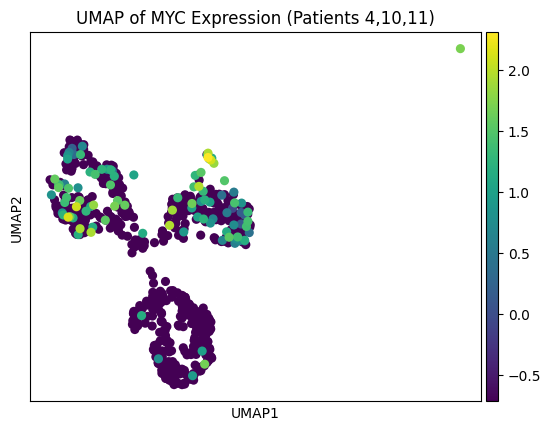

In [134]:
patients_of_interest2 = ['P4', 'P10', 'P11']
tumor_adata_filtered_subset2 = tumor_adata_filtered_subset[tumor_adata_filtered_subset.obs['patient'].isin(patients_of_interest2)]
sc.pl.umap(tumor_adata_filtered_subset2, color='MYCL', title='UMAP of MYCL Expression (Patients 4,10,11)')
sc.pl.umap(tumor_adata_filtered_subset2, color='MYC', title='UMAP of MYC Expression (Patients 4,10,11)')